<div class="alert alert-success"><h1>Preprocessing Image Data in Python</h1></div>

Before feeding raw images into a deep learning model, it's essential to transform them into a format that's easier for the model to interpret. This process is called **image preprocessing**. In this tutorial, we’ll walk through several common preprocessing steps using a small sample from the well-known **Kaggle Dogs vs. Cats** dataset.

## Learning Objectives
By the end of this tutorial, you will be able to:
+ Understand the importance of image preprocessing in deep learning workflows.
+ Load and organize image data using `image_dataset_from_directory()`.
+ Resize and center-crop images to ensure uniform input dimensions.
+ Normalize pixel values for improved model performance.

## Prerequisites
Before getting started, you should have:
+ Basic knowledge of Python programming (e.g., functions, loops, packages).
+ Familiarity with `NumPy` and `Matplotlib` for array manipulation and plotting.
+ A Python environment (version 3.x) with `tensorflow`, `keras`, `Pillow`, and `matplotlib` installed.
+ Some exposure to image data and the concept of tensors is helpful, but not required.

<hr>

The images are stored in a directory called `"train"`, with a subdirectory for cat images called `"cat"`, and another for dog images called `"dog"`. Let's preview a couple of the images to get an idea what they look like, starting with one of the cat images.

The image size is 299 by 196 pixels


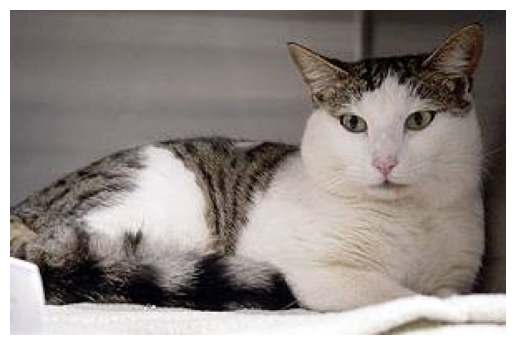

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('train/cat/cat.50.jpg')
print(f'The image size is {img.size[0]} by {img.size[1]} pixels')
plt.imshow(img)
plt.axis('off')
plt.show()

Next, let's look at one of the dog images.

The image size is 396 and 500 pixels


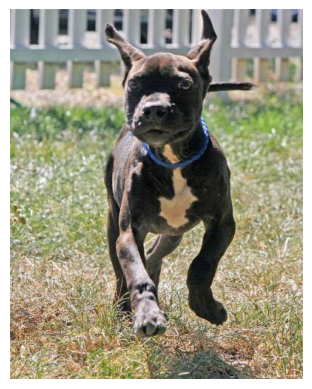

In [3]:
img = Image.open('train/dog/dog.352.jpg')
print(f'The image size is {img.size[0]} and {img.size[1]} pixels')
plt.imshow(img)
plt.axis('off')
plt.show()

## 1. Load and Batch the Images
Now that we've seen a few examples of the images we'll be working with, let's work on loading them into a format that will be useful for deep learning. When training a convolutional neural network, images are rarely processed one at a time. Instead, they are grouped into batches. A **batch** is a collection of images combined into a single tensor for efficient computation, particularly on GPUs. All images in a batch must have the same dimensions and number of channels.

Keras provides a utility function called `image_dataset_from_directory()` that allows us to create a pipeline that automatically turns images on disk into batches of **preprocessed tensors**. We're going to use it to load our data with the following configuration:
+ `labels = "inferred"`: Looks at each subfolder name under the "train" directory and assigns that folder’s index as the label.
+ `label_mode = "int"`: Stores the labels as integers. Other options include `"categorical"` for one-hot vectors, `"binary"` for the single float values of 0.0 or 1.0, or `"None"` for no labels, which is useful during inference.
+ `batch_size = 6`: Creates batches of 6 images each. When training a convolutional neural network (CNN), images are rarely processed one at a time. Instead, they are grouped into **batches** (a collection of images combined into a single tensor for efficient computation, particularly on GPUs).
+ `seed = 1234`: Randomizes the order in which files are read in a reproducible way.

<div class="alert alert-info"><b>Note:</b> For a primer on tensors and how they're used in deep learning, watch the LinkedIn Learning course <b>"Deep Learning with Python: Foundations"</b>.</div>

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = 'train'
images = image_dataset_from_directory(
    base_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size= 6,
    seed =1234
)

Found 6 files belonging to 2 classes.


Let's take a look at the imported images to see what they look like. We start by defining a reusable helper function `display_images()` that will help us display multiple images side-by-side for quick visual inspection.

In [15]:
def display_images(image_batch, label_batch):
  class_names = images.class_names
  plt.figure(figsize = (12,3))
  for i in range(len(image_batch)):
    ax = plt.subplot(1, len(image_batch), i + 1)
    img = image_batch[i].numpy().astype('uint8')
    lbl = class_names[int(label_batch[i])]
    h, w, _ = img.shape
    plt.imshow(img)
    plt.title(f'Label: {lbl}')
    plt.axis('off')
    plt.title(f'Label: {lbl}\nSize:{h}x{w}')
  plt.tight_layout()
  plt.show()

Then, we preview the imported and resized images using the `display_images()` function we just defined.

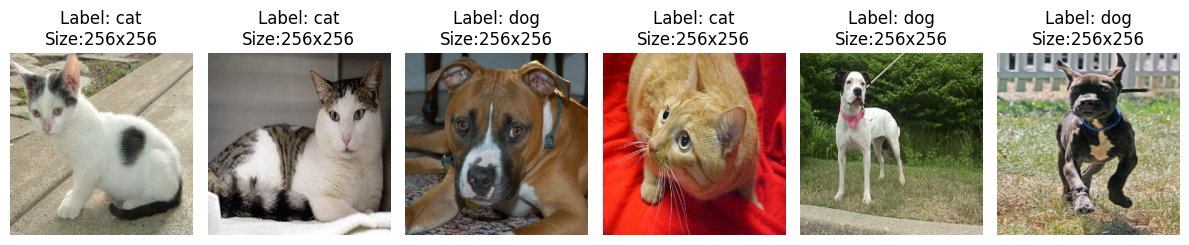

In [16]:
for image_batch, label_batch in images.take(1):
  display_images(image_batch, label_batch)

Now we see that each of the images have been resized to 256 by 256 pixels, which is the deafult image size used by `image_dataset_from_directory()` utility function. Since these are color images, each batch of 6 images would be stored as a rank-4 tensor with the shape (6, 256, 256, 3).

**Note:** If you see a message at the end of the output, it isn't an error. It's just TensorFlow’s way of saying "I've delivered all the data you asked for.".

## 2. Center-Crop and Resize
Many well-known convolutional neural network architectures use standard input sizes. For example, VGG and ResNet typically expect images of size 224 × 224 pixels, while Inception networks use 299 × 299. As a result, before we feed images to these models, they have to be adjusted to the expected size. Sometimes, this may also involve center-cropping to a square or desired aspect ratio, before resizing to avoid distortion. For example, to center-crop and resize our images to 224 x 224 pixels, we set `crop_to_aspect_ratio = True` and specify `image_size = (224, 224)`:

In [17]:
cropped_images = image_dataset_from_directory(
    base_dir,
    labels = 'inferred',
    label_mode = 'int',
    crop_to_aspect_ratio = True,
    image_size = (224, 224),
    batch_size = 6,
    seed =1234
)

Found 6 files belonging to 2 classes.


Let's preview the images to see what impact center-cropping and resizing has on them.

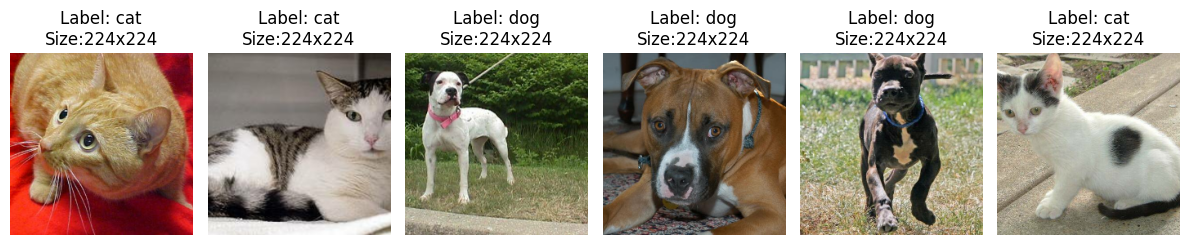

In [18]:
for image_batch, label_batch in cropped_images.take(1):
  display_images(image_batch, label_batch)

Comparing these outputs to the previous ones, we see that some of the non-cropped images (previous ones) were stretched to fit the 256 by 256 default aspect ratio, while the cropped images are trimmed, then resized to preserve the original proportions of the cat or dog in each image.

## 3. Normalize Pixel Values
Pixel values in 8-bit encoded images range from 0 to 255. Deep learning models (such as CNNs) perform better when input values are scaled to a smaller range of values. To accommodate this, we often need to normalize the pixel values so they fall within 0 and 1. There are several ways to do this. One approach is to define a preprocessing pipeline using **Keras preprocessing layers**. Each time an image passes through this layer, it will be normalized.

In [19]:
from tensorflow import keras
from keras import layers

preprocessing_layer = keras.Sequential([
    layers.Rescaling(1./255)
])

Now, let's pass all the images through the preprocessing layer.

In [20]:
normalized_images = images.map(lambda image, label : (preprocessing_layer(image), label))

To confirm the pixel ranges after normalization, let’s peek at the minimum and maximum pixel values of the images before and after:

In [22]:
import tensorflow as tf
# Peek at min/max values befor normalization
for batch, _ in images.take(1):
  print('Before normalization:',
        tf.reduce_min(batch).numpy(),
        tf.reduce_max(batch).numpy())

# Peek at min/max after normalization
for batch, _ in normalized_images.take(1):
  print('After Normalization:',
  tf.reduce_min(batch).numpy(),
  tf.reduce_max(batch). numpy())

Before normalization: 0.0 255.0
After Normalization: 0.0 1.0


This verifies that the pixel values of each image has been scaled correctly to fall within 0 and 1.

<div class="alert alert-info"><b>Note:</b> Instead of resizing images during the load process, we can resize images as part of our preprocessing pipeline by including a resizing layer (e.g., <samp>layers.Resizing(299, 299)</samp>).</div>

In this tutorial, we explored the key preprocessing steps required to prepare raw image data for use in deep learning models. You learned how to load, resize, crop, and normalize images to ensure consistency across input data. These steps help improve both the efficiency and performance of your models. In the next lesson, we’ll take things further by applying **image augmentation** techniques to expand our dataset and enhance model generalization.